## Supervised Link Prediction with the Armed Conflict Location Event Database
In this notebook, I will be turning relational data from the Armed Conflict Location & Event Data Project and turning it into several "Conflict" Undirected Graphs/Networks.

In [62]:

import sys
from collections import OrderedDict
from itertools import product
from functools import reduce
import pandas as pd
import time
present = True
import numpy as np
import re
from networkx import Graph
from functools import reduce, lru_cache
import networkx as nx
from joblib import dump, load
from sklearn.utils import resample
from itertools import product
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, f1_score

### Data Cleaning Functions

In [2]:
def load_data(path):
    data = pd.read_csv(path, index_col="data_id")
    data["event_date"] = pd.to_datetime(data["event_date"])
    return data


def load_interaction_codes(path):
    data = pd.read_csv(path)
    return data


### Data Reading Functions

In [3]:
def rename_category_columns(actor_category_df):
    return actor_category_df\
        .rename(columns={'Category_x': 'actor1_category'})\
        .rename(columns={'Category_y': 'actor2_category'})


def get_actor_categories(conflict_df, interaction_lookup):
    actor_category_df = conflict_df.copy
    actor_category_df = conflict_df\
                            .merge(interaction_lookup, 
                                   left_on="inter1", 
                                   right_on="code")\
                            .merge(interaction_lookup, 
                                   left_on="inter2", 
                                   right_on="code")
    return rename_category_columns(actor_category_df)


def subset_columns(conflict_df):
    return conflict_df[["event_date",
                        "country",
                        "actor1",
                        "actor1_category",
                        "actor2",
                        "actor2_category"]]


def get_country(string, countries):
    for country in countries:
        if country in string:
            return country

def country_extractor(conflict_df, countries):
    df = conflict_df.copy()
    df["actor1_country_temp"] = df["actor1"]\
        .apply(lambda x: get_country(x, countries))
    df["actor2_country_temp"] = df["actor2"]\
        .apply(lambda x: get_country(x, countries))

    df["actor1_country"] = np.where(df["actor1_country_temp"].isnull(),
                                    df["country"],
                                    df["actor1_country_temp"])

    df["actor2_country"] = np.where(df["actor2_country_temp"].isnull(),
                                    df["country"],
                                    df["actor2_country_temp"])

    return df[["event_date", "country", 
               "actor1", "actor1_country", "actor1_category", 
               "actor2", "actor2_country", "actor2_category"]]


### Feature Engineering Functions

In [4]:
def create_agents(conflict_df):
    df = conflict_df.copy()

    df['agent1'] = df['actor1_category'] + '-' + df['actor1_country']
    df['agent2'] = df['actor2_category'] + '-' + df['actor1_country']

    return df[["event_date", "agent1", "agent2"]]


def get_month(conflict_df):
    df = conflict_df.copy()
    df["period"] = df.event_date.dt.year.astype(str)\
      + "-" + df.event_date.dt.month.astype(str)
    return df


### Conflict Graph Function

In [5]:
class ConflictGraph(Graph):


    def __init__(self, categories, countries, period):
        super().__init__()
        self.categories = categories
        self.countries = countries
        self.period = period

    def __sort_tuple(self, tup):
        return tuple(sorted(tup))

    @lru_cache(maxsize=2)
    def __create_all_possible_nodes(self):
        return [(x + '-' + y) for x in self.categories for y in self.countries]

    @lru_cache(maxsize=2)
    def __get_node_countries(self):
        return {x + '-' + y: y for x in self.categories
                for y in self.countries}

    @lru_cache(maxsize=2)
    def __create_all_possible_edges(self):
        # Get all nodes for each timestep
        all_potential_nodes = self.__create_all_possible_nodes()
        # Create all possible combinations of nodes as tuples
        all_possible_conflicts = ((x, y) for x in all_potential_nodes
                                  for y in all_potential_nodes)
        # Order each tuple
        all_possible_conflicts_ordered = [self.__sort_tuple(edge) for edge
                                          in all_possible_conflicts]
        # Drop duplicate tuples
        all_possible_conflicts_no_dups = set(all_possible_conflicts_ordered)

        # Convert to dataframe
        all_possible_edges = pd.DataFrame(all_possible_conflicts_no_dups)
        all_possible_edges.columns = ['agent1', 'agent2']

        return all_possible_edges

    def __create_edges(self):

        if len(self.conflicts) == 0:
            return []

        edges = self.conflicts.copy()
        edges = edges.groupby(['agent1', 'agent2'])\
                     .first()\
                     .reset_index()

        # Return as list of tuples
        return edges[["agent1", "agent2"]]\
            .to_records(index=False)\
            .tolist()

    @lru_cache(maxsize=12)
    def get_edge_labels(self):

        all_possible_edges = self.__create_all_possible_edges()

        positive_edges = pd.DataFrame(self.__create_edges())
        positive_edges.columns = ["agent1", "agent2"]

        # Edges that exist get a label of 1
        positive_edges["target"] = 1

        # Join on all possible edges, those with no match, get a 0 label
        edges = positive_edges.merge(all_possible_edges,
                                     how="right",
                                     on=["agent1", "agent2"])\
                              .fillna(0)

        edges["period"] = self.period

        return edges

    def get_nodes(self):
        return self.__create_all_possible_nodes()

    def get_edges(self):
        return self.__create_edges()

    def _add_nodes(self):

        nodes = self.__create_all_possible_nodes()
        self.add_nodes_from(nodes)

    def _set_node_attributes(self):
        values = self.__get_node_countries()
        nx.set_node_attributes(self, name='country', values=values)

    def _add_edges(self):

        edges = self.__create_edges()
        if len(edges) == 0:
            pass
        else:
            self.add_edges_from(edges)

    def set_conflicts(self, conflicts):

        self.conflicts = conflicts
        self.all_possible_edges = self.__create_all_possible_edges()\
            .to_records(index=False)\
            .tolist()

        self._add_nodes()
        self._set_node_attributes()
        self._add_edges()

    def __set_suffix(self, lag=None):

        suffix = ""
        if lag:
            suffix = "_"+str(lag)+"periods_prev"

        return suffix

    def get_preferential_attachment(self, lag=None):

        suf = self.__set_suffix(lag)

        metric = nx.preferential_attachment(self, self.all_possible_edges)
        metric_df = pd.DataFrame(metric)
        metric_df.columns = ["agent1", "agent2", "pref_attachment"+suf]
        return metric_df

    def get_resource_allocation(self, lag=None):

        suf = self.__set_suffix(lag)

        metric = nx.ra_index_soundarajan_hopcroft(self,
                                                  self.all_possible_edges,
                                                  community='country')
        metric_df = pd.DataFrame(metric)
        metric_df.columns = ["agent1", "agent2", "resource_alloc_com"+suf]
        return metric_df

    def get_jaccard_coefficient(self, lag=None):

        suf = self.__set_suffix(lag)

        metric = nx.jaccard_coefficient(self, self.all_possible_edges)
        metric_df = pd.DataFrame(metric)
        metric_df.columns = ["agent1", "agent2", "jaccard_coef"+suf]
        return metric_df

    @lru_cache(maxsize=24)
    def get_all_metrics(self, lag=None):

        pref_attachment = self.get_preferential_attachment(lag)
        resource_allocation = self.get_resource_allocation(lag)
        jaccard_coefficient = self.get_jaccard_coefficient(lag)

        metrics = [pref_attachment, resource_allocation, jaccard_coefficient]

        on = ["agent1", "agent2"]

        all_metrics = reduce(
            lambda x, y: pd.merge(x, y, how='inner', on=on), metrics)

        return all_metrics


 ### Load conflict data

In [6]:
data = load_data('C:/Users/Owner/OneDrive/Desktop/ACLED/2000-01-01-2022-04-15-Afghanistan.csv')


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62243 entries, 9056716 to 8984306
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   iso               62243 non-null  int64         
 1   event_id_cnty     62243 non-null  object        
 2   event_id_no_cnty  62243 non-null  int64         
 3   event_date        62243 non-null  datetime64[ns]
 4   year              62243 non-null  int64         
 5   time_precision    62243 non-null  int64         
 6   event_type        62243 non-null  object        
 7   sub_event_type    62243 non-null  object        
 8   actor1            62243 non-null  object        
 9   assoc_actor_1     3427 non-null   object        
 10  inter1            62243 non-null  int64         
 11  actor2            60194 non-null  object        
 12  assoc_actor_2     4989 non-null   object        
 13  inter2            62243 non-null  int64         
 14  interaction   

 #### Load lookup codes
 The lookup codes for the inter columns to match them to category type
 Each actor has an associated code which represents the type of actor that they are.

In [9]:
interaction_lookup = load_interaction_codes('C:/Users/owner/OneDrive/Desktop/ACLED/categorycodes.csv')

In [10]:
interaction_lookup

,code,Category
0,1,State Forces
1,2,Rebel Groups
2,3,Political Militias
3,4,Identity Militias
4,5,Rioters
5,6,Protesters
6,7,Civilians
7,8,External/Other Forces


 #### Determine the set of all countries in the data set

In [11]:
countries = set(data.country)

 #### Define all of the possible actor countries

In [12]:
categories = list(interaction_lookup.Category)

## Create a "conflict dataframe"
 Join the interaction lookup to each actor code in order to get the category
 of actor that they are.

In [14]:
conflict_df = data.pipe(lambda x: get_actor_categories(x, interaction_lookup))\
    .pipe(subset_columns)\
    .pipe(lambda x: country_extractor(x, countries))

In [15]:
conflict_df.head()

,event_date,country,actor1,actor1_country,actor1_category,actor2,actor2_country,actor2_category
0,2022-04-08,Afghanistan,Unidentified Armed Group (Afghanistan),Afghanistan,Political Militias,Civilians (Afghanistan),Afghanistan,Civilians
1,2022-04-06,Afghanistan,Unidentified Armed Group (Afghanistan),Afghanistan,Political Militias,Civilians (Afghanistan),Afghanistan,Civilians
2,2022-04-05,Afghanistan,Unidentified Armed Group (Afghanistan),Afghanistan,Political Militias,Civilians (Afghanistan),Afghanistan,Civilians
3,2022-04-03,Afghanistan,Unidentified Armed Group (Afghanistan),Afghanistan,Political Militias,Civilians (Afghanistan),Afghanistan,Civilians
4,2022-04-01,Afghanistan,Unidentified Armed Group (Afghanistan),Afghanistan,Political Militias,Civilians (Afghanistan),Afghanistan,Civilians


## Create a dataframe of all realised conflicts between "Agents"
 This will be a dataframe of all conflicts have actually happened.

In [16]:
all_realised_conflicts = conflict_df.pipe(create_agents)\
    .pipe(get_month)

In [17]:
all_realised_conflicts.head()

,event_date,agent1,agent2,period
0,2022-04-08,Political Militias-Afghanistan,Civilians-Afghanistan,2022-4
1,2022-04-06,Political Militias-Afghanistan,Civilians-Afghanistan,2022-4
2,2022-04-05,Political Militias-Afghanistan,Civilians-Afghanistan,2022-4
3,2022-04-03,Political Militias-Afghanistan,Civilians-Afghanistan,2022-4
4,2022-04-01,Political Militias-Afghanistan,Civilians-Afghanistan,2022-4


 Define a range of monthly time periods

In [18]:
periods = [str(x)+"-"+str(y) for x, y in
           product(range(2017, 2022), range(1, 13))]

 ## Create Conflict Graphs
 For each time period, create a Conflict Graph with the conflicts that
 happened and didn't happen during that period.

In [19]:
def make_conflict_graphs(all_realised_conflicts, categories,
                         countries, periods):

    """

    For each time period, create a Conflict Graph with the conflicts that
    happened and didn't happen during that period

    """
    conflict_graphs = OrderedDict()
    counter = 0

    print('Creating Conflict Graphs....')

    for period in periods:
        counter += 1

        if counter % 20 == 0:
            print(str(counter) + " out of " + str(len(periods)))

        conflicts = all_realised_conflicts[
            all_realised_conflicts.period == period]

        cf = ConflictGraph(categories=categories,
                           countries=countries,
                           period=period)

        cf.set_conflicts(conflicts)
        conflict_graphs[period] = cf
    
    print('Conflict Graph Creation Complete')

    return conflict_graphs

 Let's see what metrics have been included by taking a sample
 graph

In [20]:
conflicts_2017_1 = all_realised_conflicts[
    all_realised_conflicts.period == '2017-1']

cf = ConflictGraph(categories=categories,
                   countries=countries,
                   period='0217-1')

cf.set_conflicts(conflicts_2017_1)

 Extract the jaccard coefficient, resource allocation and
 preferential attachment of each potential edge

In [21]:
cf.get_all_metrics()\
    .sort_values('pref_attachment', ascending=False)\
    .head()

,agent1,agent2,pref_attachment,resource_alloc_com,jaccard_coef
25,State Forces-Afghanistan,State Forces-Afghanistan,49,1.809524,0.833333
26,Rebel Groups-Afghanistan,State Forces-Afghanistan,49,0.666667,0.428571
12,Rebel Groups-Afghanistan,Rebel Groups-Afghanistan,49,1.809524,0.833333
7,Political Militias-Afghanistan,State Forces-Afghanistan,42,0.642857,0.500000
27,Political Militias-Afghanistan,Rebel Groups-Afghanistan,42,0.642857,0.500000


 Lets see what the target dataframe looks like

In [22]:
cf.get_edge_labels()\
    .sort_values('target', ascending=False)\
    .head()

,agent1,agent2,target,period
35,Protesters-Afghanistan,State Forces-Afghanistan,1.0,0217-1
7,Political Militias-Afghanistan,State Forces-Afghanistan,1.0,0217-1
25,State Forces-Afghanistan,State Forces-Afghanistan,1.0,0217-1
26,Rebel Groups-Afghanistan,State Forces-Afghanistan,1.0,0217-1
12,Rebel Groups-Afghanistan,Rebel Groups-Afghanistan,1.0,0217-1


 # Feature Extraction
 The goal is: <br>
 For each 1 month window of time where conflicts have happened,I extract a dataframe where the target is whether or not a
 conflict/edge existed during that time frame and I will extract the features
 are link prediction measures about the emerging graphs up to 10 months in the past in 1 month windows

In [24]:
def full_merge(features, target):

    """

    Merge the dataframes with the link features to the
    link target (absence/presence)

    """

    result = reduce(
        lambda x, y: x.merge(y, on=["agent1", "agent2"]),
        features)
    result = result.merge(target, on=["agent1", "agent2"])
    return result

In [25]:
def make_training_data(graphs, n_prev=12):

    """

    Implement a sliding window approach for extracting features
    and targets

    Example:
    {G1, G2, .... G12} -> G13
    {G2, G3, .... G13} -> G14

    Keyword Arguments:
    graphs -- a dictionary of Conflict Graphs
    n_prev -- The amount of time periods to slide the window
              by


    """

    keys = list(graphs.keys())
    indexes = range(len(graphs)-n_prev)

    train_dfs = []

    start = time.time()

    print('Creating Training Data...')
    for index in indexes:

        if index % 10 == 0:
            print(str(index) + " out of " + str(len(indexes)))
            print(str(time.time() - start) + " seconds elapsed")

        # Select n_prev graphs in a sliding window for feature extraction
        selected_keys_X = keys[index:index+n_prev][::-1]
        # Select a graph with a period 1 after the final graph chosen in
        # selected_keys_X
        selected_keys_Y = keys[index+n_prev]

        # Extract features/metrics for each period selected in
        # selected_keys_X
        features = (graphs[key].get_all_metrics(lag=idx+1)
                    for (idx, key) in enumerate(selected_keys_X))

        # Get the target labels for a graph 1 time period after the
        # features
        target = graphs[selected_keys_Y].get_edge_labels()

        # Merge
        result = full_merge(features, target)

        train_dfs.append(result)

        del features, target, result, selected_keys_X, selected_keys_Y

    print('Training Data Created!')

    return train_dfs

 # Creation of the Training Data via Graph Feature Extraction

In [54]:
conflict_graphs = make_conflict_graphs(all_realised_conflicts,
                                           categories,
                                           countries,
                                           periods)
train = make_training_data(conflict_graphs)
train_df = pd.concat(train, ignore_index=True)
train_df.to_parquet('df.parquet.gzip', compression='gzip')

Creating Conflict Graphs....
20 out of 60
40 out of 60
60 out of 60
Conflict Graph Creation Complete
Creating Training Data...
0 out of 48
0.0 seconds elapsed
10 out of 48
1.3186407089233398 seconds elapsed
20 out of 48
2.3660659790039062 seconds elapsed
30 out of 48
3.484961986541748 seconds elapsed
40 out of 48
4.5441060066223145 seconds elapsed
Training Data Created!


In [55]:
train_df = pd.read_parquet('df.parquet.gzip')
train_df.head()


,agent1,agent2,pref_attachment_1periods_prev,resource_alloc_com_1periods_prev,jaccard_coef_1periods_prev,pref_attachment_2periods_prev,resource_alloc_com_2periods_prev,jaccard_coef_2periods_prev,pref_attachment_3periods_prev,resource_alloc_com_3periods_prev,...,resource_alloc_com_10periods_prev,jaccard_coef_10periods_prev,pref_attachment_11periods_prev,resource_alloc_com_11periods_prev,jaccard_coef_11periods_prev,pref_attachment_12periods_prev,resource_alloc_com_12periods_prev,jaccard_coef_12periods_prev,target,period
0,External/Other Forces-Afghanistan,Protesters-Afghanistan,6,0.142857,0.25,4,0.125000,0.25,0,0.00,...,0.000000,0.0,0,0.00000,0.0,4,0.142857,0.250000,0.0,2018-1
1,Protesters-Afghanistan,Protesters-Afghanistan,4,0.309524,1.00,1,0.125000,1.00,0,0.00,...,0.000000,0.0,0,0.00000,0.0,1,0.142857,1.000000,0.0,2018-1
2,Civilians-Afghanistan,External/Other Forces-Afghanistan,12,0.309524,0.40,16,0.458333,0.60,16,0.50,...,0.309524,0.4,16,0.47619,0.6,16,0.452381,0.600000,0.0,2018-1
3,Rioters-Afghanistan,State Forces-Afghanistan,0,0.000000,0.00,0,0.000000,0.00,0,0.00,...,0.000000,0.0,7,0.00000,0.0,7,0.142857,0.166667,1.0,2018-1
4,External/Other Forces-Afghanistan,External/Other Forces-Afghanistan,9,0.559524,1.00,16,0.708333,1.00,16,0.75,...,0.559524,1.0,16,0.72619,1.0,16,0.702381,1.000000,1.0,2018-1


 # Read in training data
 From feature engineering phase

In [56]:
mode = 'read'
train_df = pd.read_parquet('df.parquet.gzip')

 ## Define the time periods of interest

In [57]:
periods = [str(x)+"-"+str(y) for x, y in
           product(range(2017, 2022), range(1, 13))]

 ## Set the test/train split
 2017-1 - 2019-6 as Train <br>
 2019-7 - 2022-12 as Test

In [58]:
training_range = periods[:48]
testing_range = periods[48:60]
train_flag = train_df.period.isin(training_range)
test_flag = train_df.period.isin(testing_range)

In [59]:
print('Creating Test/Train Splits')
train = train_df[train_flag]
test = train_df[test_flag]

Creating Test/Train Splits


In [60]:
print('Splitting Data')
X_train = train.drop('target', axis=1)\
    .set_index(["agent1", "agent2", "period"])
y_train = train\
    .set_index(["agent1", "agent2", "period"])\
    .loc[:, "target"]

X_test = test.drop('target', axis=1)\
    .set_index(["agent1", "agent2", "period"])
y_test = test\
    .set_index(["agent1", "agent2", "period"])\
    .loc[:, "target"]
print('Complete')

Splitting Data
Complete


 # Model Training
 Here I used a Balanced Random Forest from the imbalanced-learn package.

In [61]:
if mode == 'train':
    rf = BalancedRandomForestClassifier(n_jobs=5, verbose=10,
                                        n_estimators=150, random_state=123)
    rf.fit(X_train, y_train)
    dump(rf, 'model.joblib')
if mode == 'read':
    rf = load('model.joblib')

 # Model performance
 This is a very very imbalanced dataset, so accuracy shouldn't be the metric of
 overall performance.
 Accuracy doesn't tell me enough about false positives or false negatives.

 # Performance on Training data

In [40]:
y_train_pred = rf.predict(X_train)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 103 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 135 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 150 out of 150 | elapsed:    0.0s finished


 #### Confusion Matrix

Text(177.0, 0.5, 'Actual Conflicts')

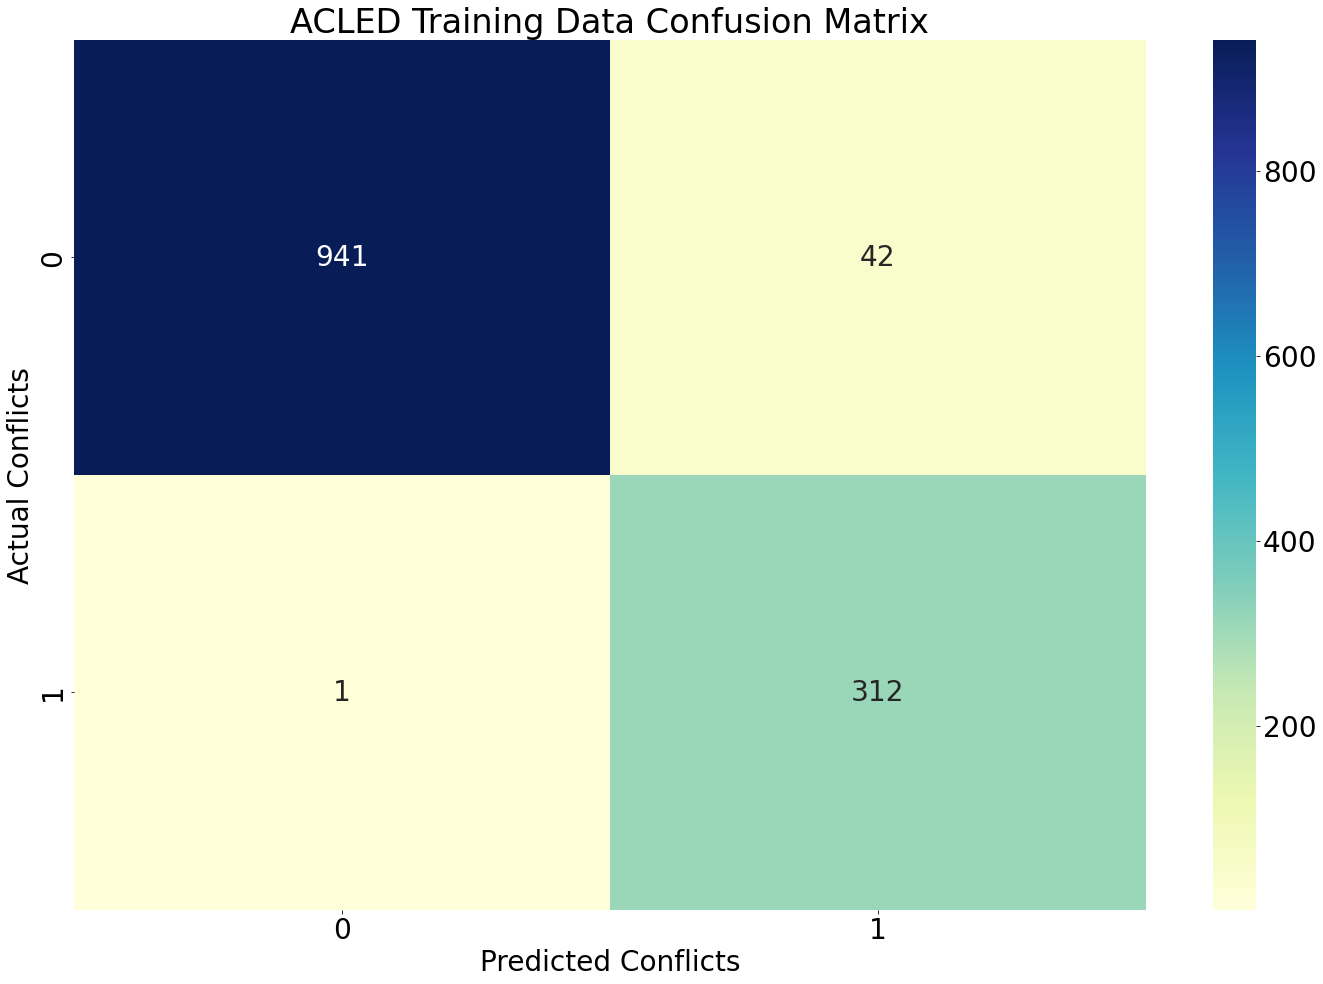

In [86]:
import seaborn as sns

cm = confusion_matrix(y_train, y_train_pred)

ax = sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu")
ax.set_title('ACLED Training Data Confusion Matrix')
ax.set_xlabel('Predicted Conflicts')
ax.set_ylabel('Actual Conflicts')

In [49]:
print("Recall Score (TRAIN): " + str(recall_score(y_train, y_train_pred)))
print("F1 (TRAIN): " + str(f1_score(y_train, y_train_pred)))

Recall Score (TRAIN): 0.9968051118210862
F1 (TRAIN): 0.9355322338830585


 # Performance on Testing data

In [50]:
y_test_pred = rf.predict(X_test)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 103 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 135 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 150 out of 150 | elapsed:    0.0s finished


 #### Confusion Matrix

Text(177.0, 0.5, 'Actual Conflicts')

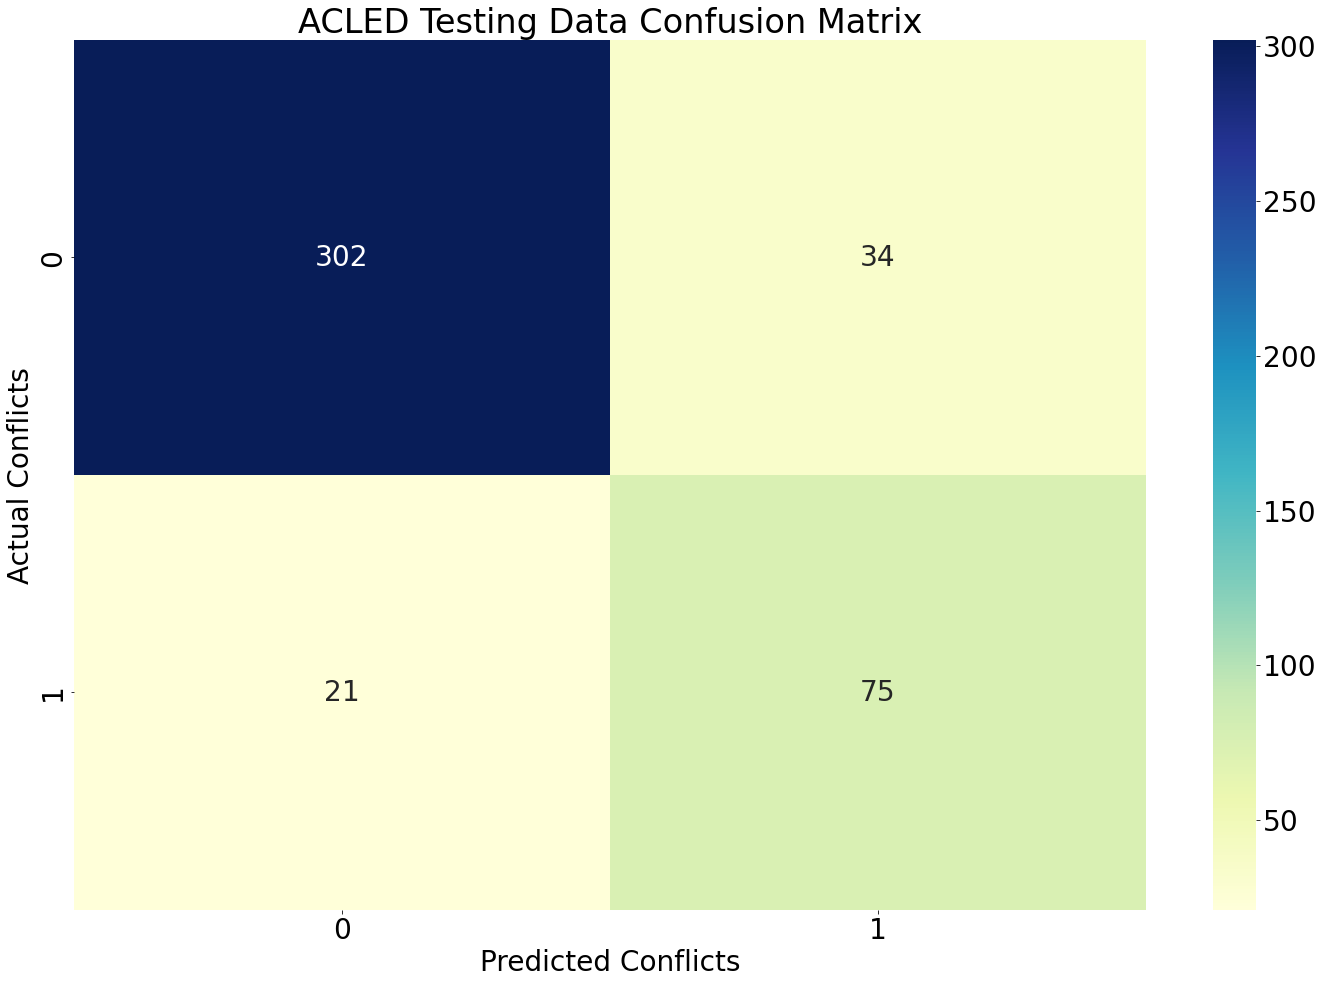

In [85]:
cm  = confusion_matrix(y_test, y_test_pred)

ax = sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu")
ax.set_title('ACLED Testing Data Confusion Matrix')
ax.set_xlabel('Predicted Conflicts')
ax.set_ylabel('Actual Conflicts')

In [52]:
print("Recall Score (TEST): " + str(recall_score(y_test, y_test_pred)))
print("F1 (TEST): " + str(f1_score(y_test, y_test_pred)))

Recall Score (TEST): 0.78125
F1 (TEST): 0.7317073170731707


 # Feature Importances

In [53]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
cols = list(X_train.columns)
# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(str(f + 1)+'. Feature: '+ cols[indices[f]] + ' '+ str(importances[indices[f]]))

Feature ranking:
1. Feature: pref_attachment_10periods_prev 0.09806227571451662
2. Feature: pref_attachment_2periods_prev 0.08008627722714633
3. Feature: pref_attachment_7periods_prev 0.07163042871983859
4. Feature: pref_attachment_8periods_prev 0.06798298361340031
5. Feature: pref_attachment_12periods_prev 0.0635015328608174
6. Feature: pref_attachment_11periods_prev 0.04394168570018339
7. Feature: pref_attachment_6periods_prev 0.04153962266652597
8. Feature: pref_attachment_5periods_prev 0.03936937358540299
9. Feature: pref_attachment_9periods_prev 0.038313194646333384
10. Feature: pref_attachment_4periods_prev 0.03633489572917685
11. Feature: pref_attachment_3periods_prev 0.033159039747163895
12. Feature: resource_alloc_com_1periods_prev 0.033072771906527694
13. Feature: pref_attachment_1periods_prev 0.031101838191136492
14. Feature: resource_alloc_com_5periods_prev 0.030546235603266598
15. Feature: resource_alloc_com_8periods_prev 0.02871926685374167
16. Feature: resource_alloc_com